In [1]:
import sklearn.preprocessing as preprocess
import numpy as np
import pandas as pd
from keras import optimizers
import keras.layers as kl
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import spacy
from keras.utils import to_categorical
from spacy.lang.en import English
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 1000)
from tqdm import tqdm_notebook
from keras.layers import BatchNormalization, Lambda, Concatenate, Dropout, Conv1D, MaxPooling1D, Input, TimeDistributed, Dense, LSTM, RepeatVector, GlobalAveragePooling1D
from keras.models import Model
import pickle
from datetime import datetime
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from AttentionModules import SelfAttention, CrossAttention
import sys,os
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Using TensorFlow backend.


In [2]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
dnf700 = pd.read_json('evaluation_set/deepnofakes/dnf_700/initial.json')
dnf_eval = pd.read_json('evaluation_set/deepnofakes/Evaluation_Final_50_V4.json')
dnf_eval.columns = ['authors','claim_ids', 'evidence', 'headline', 'id', 'reason', 'claims', 'type', 'urls'] 
with open('evaluation_set/deepnofakes/dnf_700/dnf700_sent_array_id.p', 'rb') as fp:
    articles = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_700/dnf700_sent_vector_array_id.p', 'rb') as fp:
    article_vectors = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_array_id.p', 'rb') as fp:
    articles300 = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_vector_array_id.p', 'rb') as fp:
    article_vectors300 = pickle.load(fp)
with open('evaluation_set/word_mapping/id_word_mapping.p', 'rb') as fp:
    id_word_mapping = pickle.load(fp)
dnf_eval.keys(), dnf700.keys(), len(articles.keys()), len(article_vectors.keys())

(Index(['authors', 'claim_ids', 'evidence', 'headline', 'id', 'reason',
        'claims', 'type', 'urls'],
       dtype='object'),
 Index(['authors', 'headline', 'id', 'type', 'urls'], dtype='object'),
 705,
 705)

In [4]:
num_splits = 5
kf = KFold(n_splits=num_splits)
train_batchsize = 32
val_batchsize = 32
test_batchsize = 50
train_steps_per_epoch = 4
val_steps_per_epoch = 1
epochs = 2000
max_sentences = 500
# for idx in articles.keys():
#     num = len(articles[idx])
#     if num>=max_sentences:
#         max_sentences = num
        
max_sentences

500

In [5]:
hdl = "George Soros: Trump Will Win Popular Vote by a Landslide but Clinton Victory a 'Done Deal'"
hdl = "Ted Cruz Said 'If Something Happens to Hillary' He'll 'Run as a Democrat Against Trump'"
# hdl = "If You Thought The Trump Child Rape Case In NY Couldn’t Get Much Worse — You Were Wrong"
# hdl = "California Set to Let Public Schools Teach Primarily in Spanish"
dnf700[dnf700.headline==hdl]

,authors,headline,id,type,urls


In [6]:
titles = sorted(dnf700.headline.unique())
len(titles)

698

In [7]:
test_titles = sorted(dnf_eval.headline.unique())
len(test_titles)
test_titles

['(VIDEO) Female College Students Protesting Because ‘Trump is a Rapist’',
 'Assange Confirms: WikiLeaks Didn’t Get Emails From Russian Govt',
 'BREAKING: Fraudulent Clinton Votes Discovered By The Tens Of Thousands',
 "Clinton Camp Demands 'Compliant Citizenry' for Master Plan",
 'Clinton Received Debate Questions Week Before Debate',
 "DOJ's Loretta Lynch Tried To Squash Comey's Letter To Congress",
 'Department of Homeland Security Chairman Officially Indicts Hillary Clinton of Treason',
 'Developing: Obama WH admits that Hillary gave ISIS $400 million on accident',
 'Erdoğan: US, the founder of ISIS',
 "FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Healthcare Begins With A Bombshell! » 100percentfedUp.com",
 'FBI Agent Suspected in Hillary Email Leaks Found Dead in Apparent Murder-Suicide',
 'FBI Director Comey’s ‘Leaked’ Memo Explains Why He’s Reopening the Clinton Email Case',
 'FBI director received millions from Clinton Foundation, his brother’s law firm does Clinton’s taxes',
 'Fo

In [8]:
non_test_titles = np.array(list(set(titles)-set(test_titles)))
len(non_test_titles)

653

In [9]:
indices = []
for train_index, val_index in kf.split(non_test_titles):
    indices.append([train_index,val_index])

In [10]:

train_index, val_index = indices[np.random.randint(0,num_splits)]
print(train_index,val_index)
val_titles = non_test_titles[val_index]
train_titles = non_test_titles[train_index]
len(train_titles),len(val_titles),len(test_titles)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

(523, 130, 50)

In [11]:
def load_spacy():
    sentencizer = English()
    sentencizer.add_pipe(sentencizer.create_pipe('sentencizer'))
    nlp = spacy.load("en_core_web_md")
    return sentencizer, nlp
sentencizer, nlp = load_spacy()


In [12]:

def datagen_dnf(batchsize,dataframe,mode):
    counter=0
    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]
    while True:
        if mode=='train':
            idx=np.random.choice(train_titles)
        elif mode=='val':
            idx=np.random.choice(val_titles)
        elif mode=='test':
            idx=np.random.choice(test_titles)
        idx = idx.strip()
        
            
#         cl = dataframe[dataframe.Article==idx]['Claim'].values
#         sentences=articles[ar_id]
#         print(len(sentences))
        if mode=='test':
            hd = dnf_eval[dnf_eval.headline==idx]['headline'].values[0].lower()
            ar_id = dnf_eval[dnf_eval.headline==idx]['id'].values[0]
            cl = dnf_eval[dnf_eval.headline==idx]['claims'].values[0]
            ar_claims.append(cl)
            sentences = articles300[ar_id]
            vectors = article_vectors300[ar_id]
        else:
            try:
                hd = dataframe[dataframe.headline==idx]['headline'].values[0].lower()
                ar_id = dataframe[dataframe.headline==idx]['id'].values[0]
                ar_claims.append('None')
                sentences=articles[ar_id]
                vectors = article_vectors[ar_id]
            except Exception as ex:
                print(ex)
                print(idx)
            
        hds.append(hd)
        ar_sentences.append(sentences)
#         print(len(sentences))
        sents = np.zeros((max_sentences,300))
        
        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        hd_nlp = hd_nlp[:50]
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
        counter+=1
        if counter==batchsize:
            inputs = {
                'article_id': np.array(ar_ids)
                ,'headline': np.array(hds)
                ,'sentence_vectors' : np.array(ar_sents)
                ,'input_headline_vector': np.array(ar_head_vectors)
                ,'claims':np.array(ar_claims)
                ,'sentences':np.array(ar_sentences)
            }
            outputs = {
                'headline_token_classes': np.array(ar_head_classes)
                ,'output_headline_vector': np.array(ar_head_vectors)
            }
            yield inputs,outputs
            ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]
            counter=0
 

In [13]:
tdg = datagen_dnf(train_batchsize,dnf700,mode='train')
vdg = datagen_dnf(val_batchsize,dnf700,mode='val')
test_dg = datagen_dnf(test_batchsize,dnf700,mode='test')

In [14]:
x,y = next(test_dg)

In [15]:
# x['sentence_vectors'].shape, x['headline_vector'].shape, y['headline_token_classes'].shape

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 500, 300)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 500, 16)      14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 500, 16)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 500, 32)      1568        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

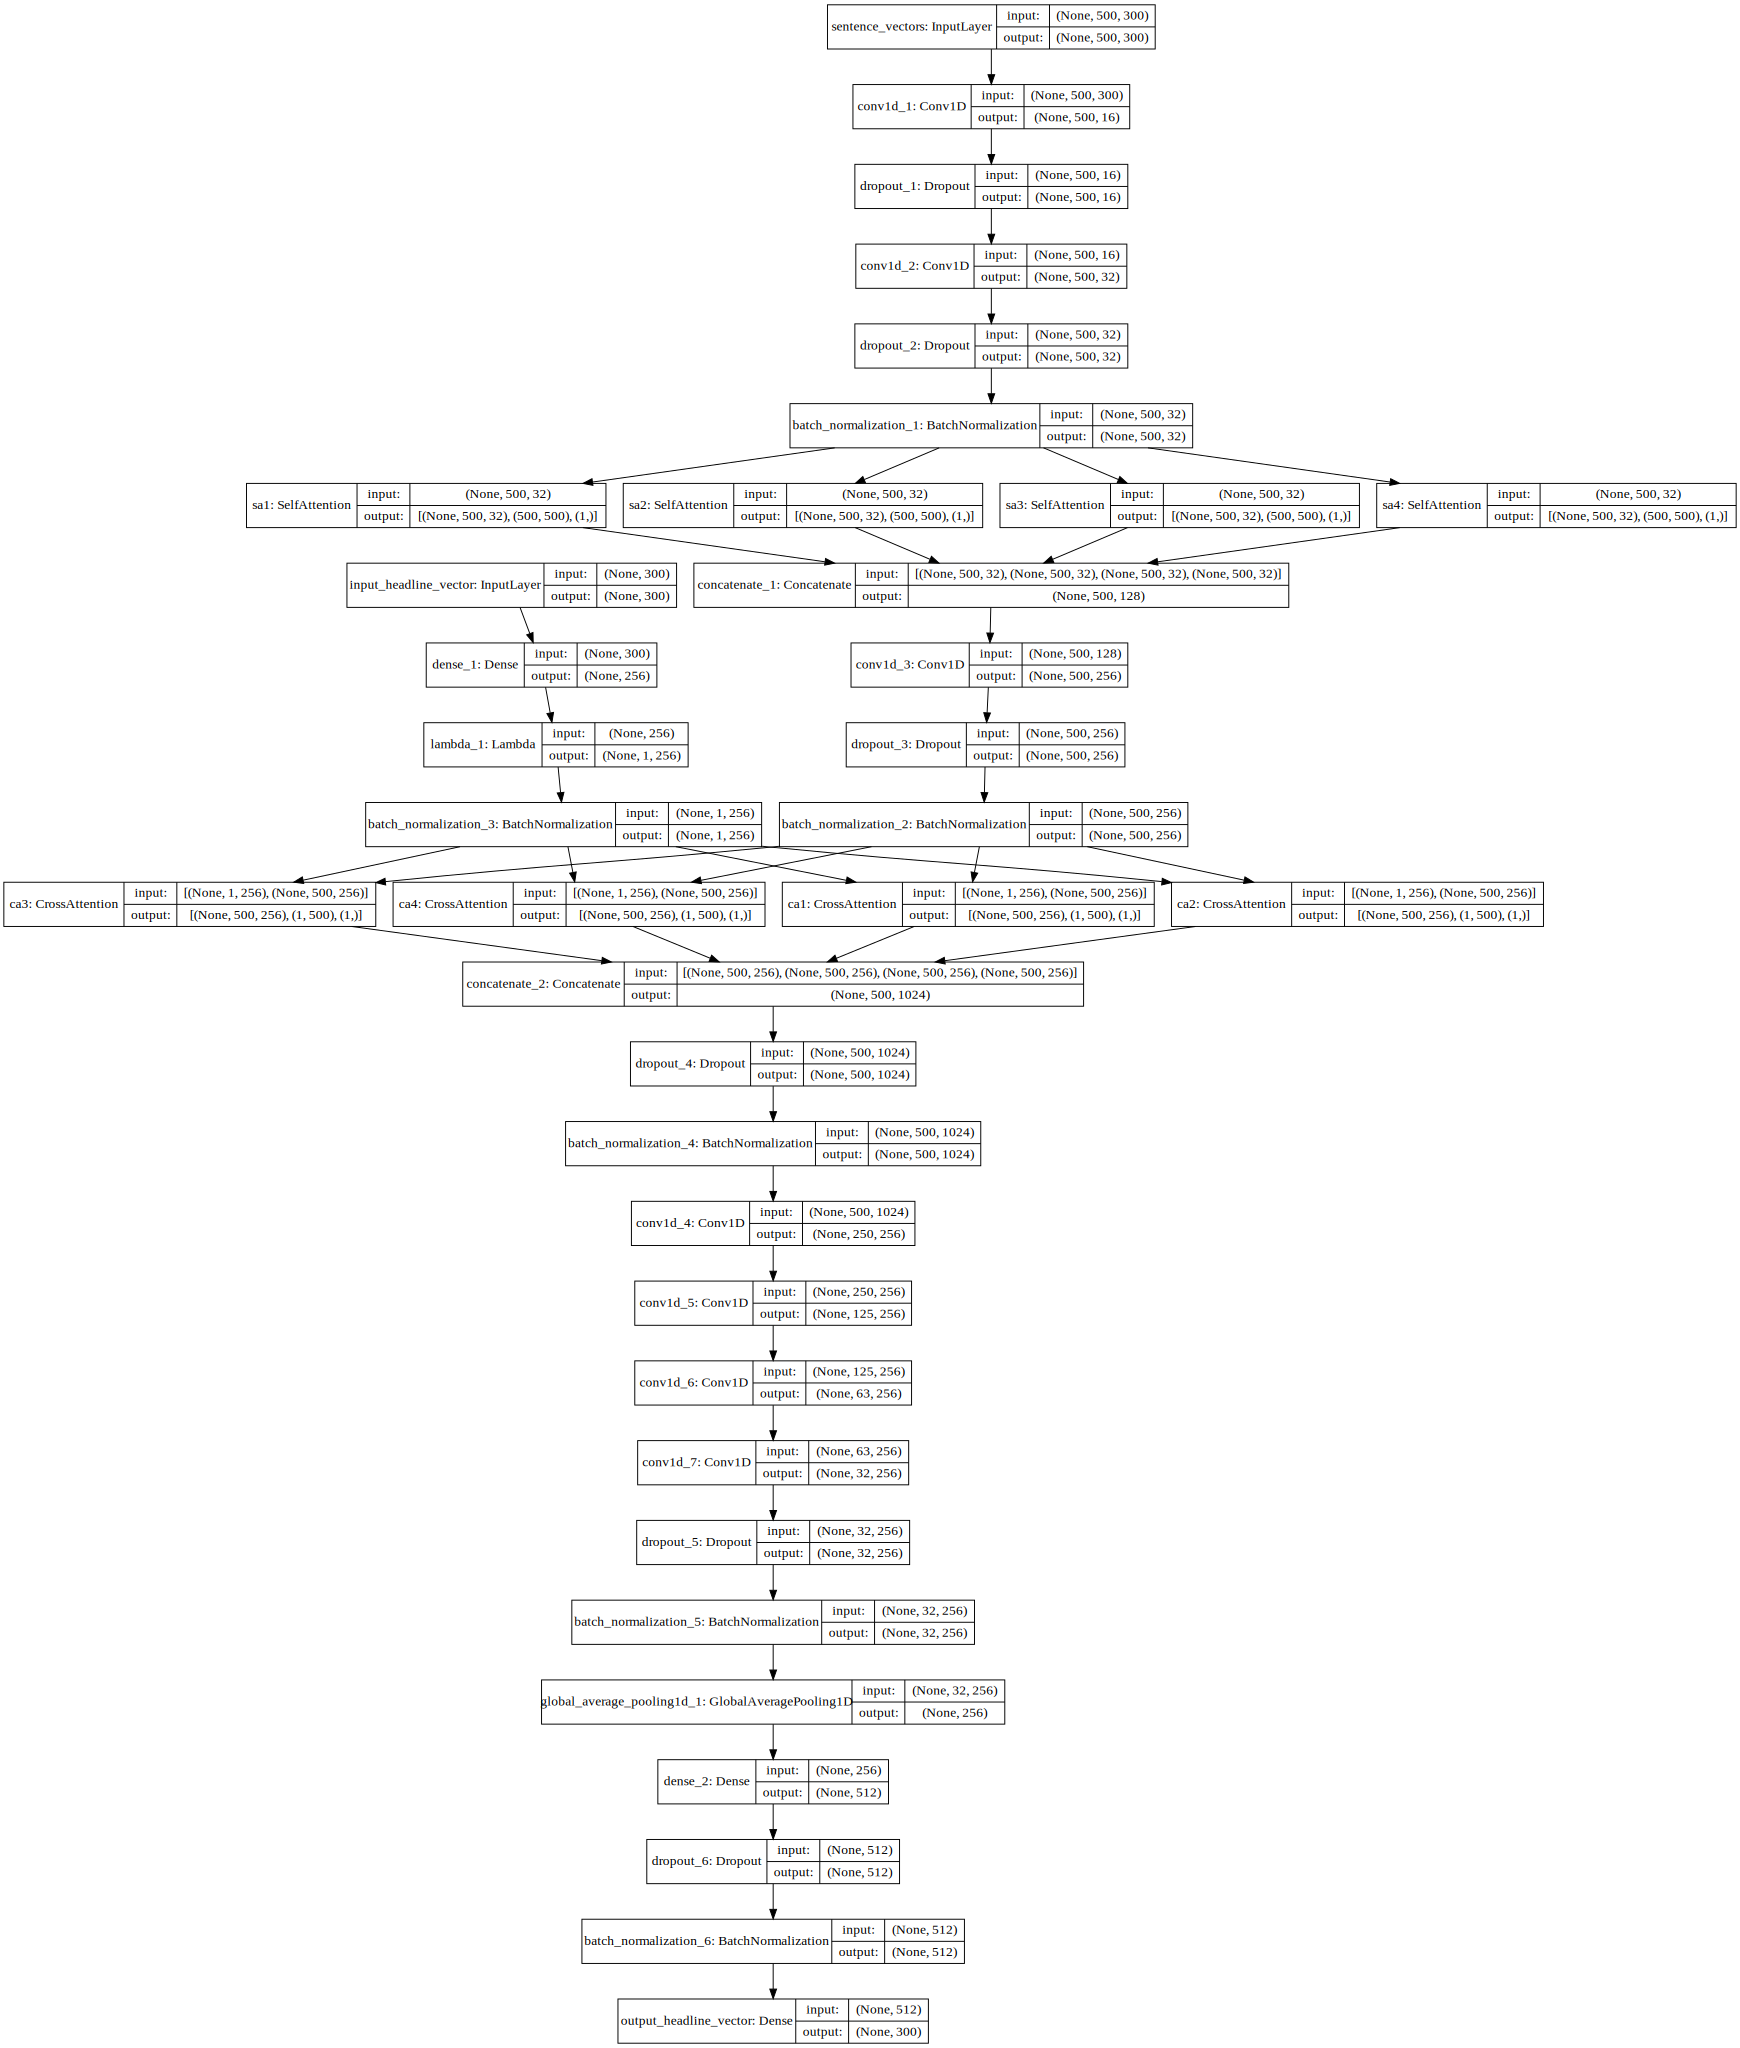

In [16]:
def build_model():
    inp_sentence_vectors = Input(shape=(max_sentences, 300), name='sentence_vectors')
    inp_headline_vector = Input(shape=(300,), name='input_headline_vector')
    conv1 = Conv1D(filters=16,kernel_size=3,strides=1,activation='relu', padding='same')(inp_sentence_vectors)
    conv1 = Dropout(0.5)(conv1)
    conv2 = Conv1D(filters=32,kernel_size=3,strides=1,activation='relu', padding='same')(conv1)
    conv2 = Dropout(0.5)(conv2)
    conv2 = BatchNormalization()(conv2)
    sent_sa_feat_1, sent_beta_1, sent_gamma_1 = SelfAttention(int(conv2.shape[-1]), name = 'sa1')(conv2)
    sent_sa_feat_2, sent_beta_2, sent_gamma_2 = SelfAttention(int(conv2.shape[-1]), name = 'sa2')(conv2)
    sent_sa_feat_3, sent_beta_3, sent_gamma_3 = SelfAttention(int(conv2.shape[-1]), name = 'sa3')(conv2)
    sent_sa_feat_4, sent_beta_4, sent_gamma_4 = SelfAttention(int(conv2.shape[-1]), name = 'sa4')(conv2)
    concat1 = Concatenate()([sent_sa_feat_1,sent_sa_feat_2,sent_sa_feat_3,sent_sa_feat_4])
    conv3 = Conv1D(filters=256,kernel_size=3, strides=1, activation='relu', padding='same')(concat1)
    conv3 = Dropout(0.5)(conv3)
    conv3 = BatchNormalization()(conv3)
    headline = Dense(256, activation='relu')(inp_headline_vector)
    headline = Lambda(lambda x:K.expand_dims(x, axis=1))(headline)
    headline = BatchNormalization()(headline)
    sent_hd_sa_feat_1, sent_hd_beta_1, sent_hd_gamma_1 = CrossAttention(int(conv3.shape[-1]), name = 'ca1')([headline,conv3])
    sent_hd_sa_feat_2, sent_hd_beta_2, sent_hd_gamma_2 = CrossAttention(int(conv3.shape[-1]), name = 'ca2')([headline,conv3])
    sent_hd_sa_feat_3, sent_hd_beta_3, sent_hd_gamma_3 = CrossAttention(int(conv3.shape[-1]), name = 'ca3')([headline,conv3])
    sent_hd_sa_feat_4, sent_hd_beta_4, sent_hd_gamma_4 = CrossAttention(int(conv3.shape[-1]), name = 'ca4')([headline,conv3])  
    concat3 = Concatenate()([sent_hd_sa_feat_1,sent_hd_sa_feat_2,sent_hd_sa_feat_3,sent_hd_sa_feat_4])
    concat3 = Dropout(0.5)(concat3)
    concat3 = BatchNormalization()(concat3)
    conv5 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(concat3)
    conv6 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv5)
    conv7 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv6)
    conv8 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv7)
    conv8 = Dropout(0.5)(conv8)
    conv8 = BatchNormalization()(conv8)
    gap = GlobalAveragePooling1D()(conv8)
#     repeat = RepeatVector(50)(gap)
#     lstm = LSTM(256,return_sequences=True)(repeat)
    dense1 = Dense(512,activation='relu')(gap)
    dense1 = Dropout(0.5)(dense1)
    dense1 = BatchNormalization()(dense1)
    gen_hd_vector = Dense(300,activation='linear', name='output_headline_vector')(dense1)
    model = Model([inp_sentence_vectors,inp_headline_vector],gen_hd_vector)
    return model
model = build_model()
model.compile(optimizer=optimizers.Adam(lr=0.0001,beta_1=0.0,beta_2=0.99),loss='mse')
model.summary()
# print('model params:',model.count_params())
SVG(model_to_dot(model,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg'))

In [17]:
dt = datetime.now()
mc = ModelCheckpoint('weights/dnf700_sa_sent_hd_vector_gl.hdf5',save_best_only=True,save_weights_only=True)
tb = TensorBoard(batch_size=32,log_dir='logs/dnf700_sa_sent_hd_vector_gl/{0}'.format(dt.timestamp()),write_graph=True)

In [18]:
hist = model.fit_generator(tdg, callbacks=[mc,tb], initial_epoch=0
                           ,steps_per_epoch=train_steps_per_epoch
                           ,validation_data=vdg
                           ,validation_steps=val_steps_per_epoch
                           ,epochs=epochs)

Epoch 1/2000
4/4 [==============================] - 14s 3s/step - loss: 1.1550 - val_loss: 0.3712
Epoch 2/2000
4/4 [==============================] - 0s 109ms/step - loss: 1.1650 - val_loss: 0.3526
Epoch 3/2000
4/4 [==============================] - 0s 111ms/step - loss: 1.1615 - val_loss: 0.3359
Epoch 4/2000
4/4 [==============================] - 3s 725ms/step - loss: 1.1248 - val_loss: 0.3075
Epoch 5/2000
4/4 [==============================] - 3s 810ms/step - loss: 1.1313 - val_loss: 0.2789
Epoch 6/2000
4/4 [==============================] - 3s 706ms/step - loss: 1.1184 - val_loss: 0.2711
Epoch 7/2000
4/4 [==============================] - 3s 794ms/step - loss: 1.1070 - val_loss: 0.2639
Epoch 8/2000
4/4 [==============================] - 3s 674ms/step - loss: 1.0799 - val_loss: 0.2310
Epoch 9/2000
4/4 [==============================] - 3s 674ms/step - loss: 1.0988 - val_loss: 0.2132
Epoch 10/2000
4/4 [==============================] - 3s 670ms/step - loss: 1.0608 - val_loss: 0.2084
E

4/4 [==============================] - 10s 3s/step - loss: 0.1520 - val_loss: 0.0534
Epoch 167/2000
4/4 [==============================] - 9s 2s/step - loss: 0.1366 - val_loss: 0.0572
Epoch 168/2000
4/4 [==============================] - 10s 3s/step - loss: 0.1315 - val_loss: 0.1035
Epoch 169/2000
4/4 [==============================] - 9s 2s/step - loss: 0.1520 - val_loss: 0.2119
Epoch 170/2000
4/4 [==============================] - 10s 2s/step - loss: 0.1338 - val_loss: 0.1910
Epoch 171/2000
4/4 [==============================] - 11s 3s/step - loss: 0.1472 - val_loss: 0.0137
Epoch 172/2000
4/4 [==============================] - 10s 3s/step - loss: 0.1399 - val_loss: 0.0155
Epoch 173/2000
4/4 [==============================] - 10s 3s/step - loss: 0.1366 - val_loss: 0.0166
Epoch 174/2000
4/4 [==============================] - 10s 2s/step - loss: 0.1373 - val_loss: 0.0124
Epoch 175/2000
4/4 [==============================] - 10s 2s/step - loss: 0.1395 - val_loss: 0.0131
Epoch 176/2000
4/

4/4 [==============================] - 14s 3s/step - loss: 0.0712 - val_loss: 0.0113
Epoch 249/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0647 - val_loss: 0.0106
Epoch 250/2000
4/4 [==============================] - 14s 3s/step - loss: 0.0487 - val_loss: 0.0125
Epoch 251/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0535 - val_loss: 0.0490
Epoch 252/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0525 - val_loss: 0.2778
Epoch 253/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0553 - val_loss: 0.0105
Epoch 254/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0544 - val_loss: 0.0107
Epoch 255/2000
4/4 [==============================] - 14s 3s/step - loss: 0.0488 - val_loss: 0.0199
Epoch 256/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0536 - val_loss: 0.0358
Epoch 257/2000
4/4 [==============================] - 14s 3s/step - loss: 0.0531 - val_loss: 0.0266
Epoch 258/2000


4/4 [==============================] - 15s 4s/step - loss: 0.0138 - val_loss: 0.0125
Epoch 331/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0134 - val_loss: 0.0101
Epoch 332/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0122 - val_loss: 0.0108
Epoch 333/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0136 - val_loss: 0.0134
Epoch 334/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0133 - val_loss: 0.0124
Epoch 335/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0126 - val_loss: 0.0118
Epoch 336/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0123 - val_loss: 0.0106
Epoch 337/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0125 - val_loss: 0.0100
Epoch 338/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0125 - val_loss: 0.0110
Epoch 339/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0135 - val_loss: 0.0123
Epoch 340/2000


4/4 [==============================] - 15s 4s/step - loss: 0.0105 - val_loss: 0.0119
Epoch 413/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0112 - val_loss: 0.0106
Epoch 414/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0125 - val_loss: 0.0108
Epoch 415/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0114 - val_loss: 0.0120
Epoch 416/2000
4/4 [==============================] - 14s 3s/step - loss: 0.0112 - val_loss: 0.0094
Epoch 417/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0105 - val_loss: 0.0111
Epoch 418/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0117 - val_loss: 0.0115
Epoch 419/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0120 - val_loss: 0.0099
Epoch 420/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0110 - val_loss: 0.0107
Epoch 421/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0117 - val_loss: 0.0095
Epoch 422/2000


4/4 [==============================] - 16s 4s/step - loss: 0.0107 - val_loss: 0.0105
Epoch 495/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0117 - val_loss: 0.0125
Epoch 496/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0107 - val_loss: 0.0126
Epoch 497/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0101 - val_loss: 0.0100
Epoch 498/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0112 - val_loss: 0.0114
Epoch 499/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0109 - val_loss: 0.0113
Epoch 500/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0126 - val_loss: 0.0103
Epoch 501/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0110 - val_loss: 0.0116
Epoch 502/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0130 - val_loss: 0.0119
Epoch 503/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0107 - val_loss: 0.0123
Epoch 504/2000


4/4 [==============================] - 16s 4s/step - loss: 0.0110 - val_loss: 0.0114
Epoch 577/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0115 - val_loss: 0.0112
Epoch 578/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0110 - val_loss: 0.0150
Epoch 579/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0123 - val_loss: 0.0102
Epoch 580/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0120 - val_loss: 0.0118
Epoch 581/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0110 - val_loss: 0.0109
Epoch 582/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0106 - val_loss: 0.0093
Epoch 583/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0125 - val_loss: 0.0109
Epoch 584/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0111 - val_loss: 0.0109
Epoch 585/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0103 - val_loss: 0.0091
Epoch 586/2000


4/4 [==============================] - 15s 4s/step - loss: 0.0110 - val_loss: 0.0106
Epoch 659/2000
4/4 [==============================] - 13s 3s/step - loss: 0.0121 - val_loss: 0.0113
Epoch 660/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0106 - val_loss: 0.0116
Epoch 661/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0108 - val_loss: 0.0097
Epoch 662/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0112 - val_loss: 0.0105
Epoch 663/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0106 - val_loss: 0.0106
Epoch 664/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0116 - val_loss: 0.0090
Epoch 665/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0124 - val_loss: 0.5483
Epoch 666/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0112 - val_loss: 0.0128
Epoch 667/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0112 - val_loss: 0.2710
Epoch 668/2000


4/4 [==============================] - 16s 4s/step - loss: 0.0112 - val_loss: 0.0091
Epoch 741/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0110 - val_loss: 0.0125
Epoch 742/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0124 - val_loss: 0.0113
Epoch 743/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0109 - val_loss: 0.0114
Epoch 744/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0099 - val_loss: 0.0107
Epoch 745/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0104 - val_loss: 0.0127
Epoch 746/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0104 - val_loss: 0.0092
Epoch 747/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0116 - val_loss: 0.0114
Epoch 748/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0119 - val_loss: 0.0114
Epoch 749/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0117 - val_loss: 0.0095
Epoch 750/2000


4/4 [==============================] - 15s 4s/step - loss: 0.0104 - val_loss: 0.0112
Epoch 823/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0109 - val_loss: 0.0123
Epoch 824/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0111 - val_loss: 0.0123
Epoch 825/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0107 - val_loss: 0.0132
Epoch 826/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0127 - val_loss: 0.0114
Epoch 827/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0114 - val_loss: 0.0107
Epoch 828/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0100 - val_loss: 0.0122
Epoch 829/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0114 - val_loss: 0.0109
Epoch 830/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0116 - val_loss: 0.0092
Epoch 831/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0104 - val_loss: 0.0086
Epoch 832/2000


4/4 [==============================] - 15s 4s/step - loss: 0.0104 - val_loss: 0.0110
Epoch 905/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0111 - val_loss: 0.0103
Epoch 906/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0110 - val_loss: 0.0116
Epoch 907/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0106 - val_loss: 0.0108
Epoch 908/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0121 - val_loss: 0.0084
Epoch 909/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0112 - val_loss: 0.0122
Epoch 910/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0102 - val_loss: 0.0118
Epoch 911/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0114 - val_loss: 0.0115
Epoch 912/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0104 - val_loss: 0.0098
Epoch 913/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0109 - val_loss: 0.0102
Epoch 914/2000


4/4 [==============================] - 14s 4s/step - loss: 0.0116 - val_loss: 0.0094
Epoch 987/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0107 - val_loss: 0.0086
Epoch 988/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0118 - val_loss: 0.0112
Epoch 989/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0104 - val_loss: 0.0120
Epoch 990/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0110 - val_loss: 0.0124
Epoch 991/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0120 - val_loss: 0.0091
Epoch 992/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0108 - val_loss: 0.0097
Epoch 993/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0122 - val_loss: 0.0101
Epoch 994/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0108 - val_loss: 0.0117
Epoch 995/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0111 - val_loss: 0.0112
Epoch 996/2000


4/4 [==============================] - 16s 4s/step - loss: 0.0109 - val_loss: 0.0117
Epoch 1149/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0112 - val_loss: 0.0111
Epoch 1150/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0110 - val_loss: 0.0099
Epoch 1151/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0104 - val_loss: 0.0103
Epoch 1152/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0113 - val_loss: 0.0103
Epoch 1153/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0104 - val_loss: 0.0114
Epoch 1154/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0116 - val_loss: 0.0129
Epoch 1155/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0116 - val_loss: 0.0094
Epoch 1156/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0108 - val_loss: 0.0108
Epoch 1157/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0116 - val_loss: 0.0125
Epoch 

4/4 [==============================] - 15s 4s/step - loss: 0.0105 - val_loss: 0.0100
Epoch 1311/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0107 - val_loss: 0.0106
Epoch 1312/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0109 - val_loss: 0.0146
Epoch 1313/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0118 - val_loss: 0.0106
Epoch 1314/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0108 - val_loss: 0.0127
Epoch 1315/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0112 - val_loss: 0.0108
Epoch 1316/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0110 - val_loss: 0.0098
Epoch 1317/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0107 - val_loss: 0.0098
Epoch 1318/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0110 - val_loss: 0.0120
Epoch 1319/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0112 - val_loss: 0.0104
Epoch 

4/4 [==============================] - 15s 4s/step - loss: 0.0105 - val_loss: 0.0123
Epoch 1473/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0101 - val_loss: 0.0117
Epoch 1474/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0123 - val_loss: 0.0111
Epoch 1475/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0108 - val_loss: 0.0112
Epoch 1476/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0111 - val_loss: 0.0124
Epoch 1477/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0101 - val_loss: 0.0112
Epoch 1478/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0116 - val_loss: 0.0106
Epoch 1479/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0126 - val_loss: 0.0113
Epoch 1480/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0099 - val_loss: 0.0105
Epoch 1481/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0106 - val_loss: 0.0118
Epoch 

4/4 [==============================] - 15s 4s/step - loss: 0.0114 - val_loss: 0.0098
Epoch 1635/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0106 - val_loss: 0.0106
Epoch 1636/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0115 - val_loss: 0.0124
Epoch 1637/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0116 - val_loss: 0.0104
Epoch 1638/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0112 - val_loss: 0.0108
Epoch 1639/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0106 - val_loss: 0.0103
Epoch 1640/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0118 - val_loss: 0.0087
Epoch 1641/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0107 - val_loss: 0.0110
Epoch 1642/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0111 - val_loss: 0.0096
Epoch 1643/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0120 - val_loss: 0.0108
Epoch 

4/4 [==============================] - 15s 4s/step - loss: 0.0113 - val_loss: 0.3172
Epoch 1797/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0118 - val_loss: 131.0215
Epoch 1798/2000
4/4 [==============================] - 14s 3s/step - loss: 0.0113 - val_loss: 5.4145
Epoch 1799/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0119 - val_loss: 2.0618
Epoch 1800/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0124 - val_loss: 0.9648
Epoch 1801/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0100 - val_loss: 0.4657
Epoch 1802/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0106 - val_loss: 0.2099
Epoch 1803/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0104 - val_loss: 0.1004
Epoch 1804/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0107 - val_loss: 0.0160
Epoch 1805/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0128 - val_loss: 0.0134
Epoc

4/4 [==============================] - 16s 4s/step - loss: 0.0110 - val_loss: 0.0109
Epoch 1959/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0113 - val_loss: 0.0102
Epoch 1960/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0100 - val_loss: 0.0104
Epoch 1961/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0103 - val_loss: 0.0105
Epoch 1962/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0102 - val_loss: 0.0119
Epoch 1963/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0115 - val_loss: 0.0111
Epoch 1964/2000
4/4 [==============================] - 15s 4s/step - loss: 0.0116 - val_loss: 0.0120
Epoch 1965/2000
4/4 [==============================] - 14s 3s/step - loss: 0.0107 - val_loss: 0.0104
Epoch 1966/2000
4/4 [==============================] - 14s 4s/step - loss: 0.0117 - val_loss: 0.0122
Epoch 1967/2000
4/4 [==============================] - 16s 4s/step - loss: 0.0106 - val_loss: 0.0097
Epoch 

In [19]:
# from matplotlib import pyplot as plt
# acc = hist.history['acc']
# loss = hist.history['loss']

# # Create count of the number of epochs
# epoch_count = range(1, len(acc) + 1)

# # Visualize loss history
# # plt.plot(epoch_count, acc, 'b-')
# fig, ax = plt.subplots(ncols=2,sharex=True)
# ax[0].plot(epoch_count, loss, 'r--')
# ax[0].legend(['Loss'])
# ax[0].set_xlabel('Epoch')
# ax[0].set_ylabel('Loss')
# ax[1].plot(epoch_count, acc, 'b-')
# ax[1].legend(['Accuracy'])
# ax[1].set_xlabel('Epoch')
# ax[1].set_xlabel('Accuracy')
# plt.show();

In [20]:
# df_res = pd.DataFrame(hist.history)

In [21]:
# df_res[['loss','val_loss']].plot()

In [22]:
# # df_res[['acc','val_acc']].plot()
# hd_nlp = nlp("What is you name my name is Anthony Gonsalves What is you name my name is Anthony GonsalvesWhat is you name my name is Anthony GonsalvesWhat is you name my name is Anthony GonsalvesWhat is you name my name is Anthony GonsalvesWhat is you name my name is Anthony Gonsalves!".lower())
# len(hd_nlp[:50])

# Evalutate SST

In [23]:
model.load_weights('weights/dnf700_sa_sent_hd_vector_gl.hdf5')
model.evaluate_generator(test_dg,steps=5,pickle_safe = True)

/home/mshaikh2/anaconda3/envs/tf-gpu/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `evaluate_generator` call to the Keras 2 API: `evaluate_generator(<generator..., steps=5, use_multiprocessing=True)`
  


0.01053589079529047

In [24]:
x,y = next(test_dg)
pred = model.predict(x)

In [25]:
x['headline']

array(['breaking: fraudulent clinton votes discovered by the tens of thousands',
       'hillary clinton used hand signals to rig debate?',
       "george soros: trump will win popular vote by a landslide but clinton victory a 'done deal'",
       "clinton camp demands 'compliant citizenry' for master plan",
       'top aide: hillary ‘still not perfect in her head’, wikileaks',
       'julian assange makes very suspect post election announcement, seeks pardon from trump',
       'breaking: fraudulent clinton votes discovered by the tens of thousands',
       "hillary clinton cut her tax bill by 'donating' $1 million to herself via the clinton foundation?",
       'pentagon officials furious after clinton announces us response time for nuclear launch during debate',
       'hillary’s (islamic) america is already here where ‘muslim no-go zones’ are popping up all over michiganistan',
       'wikileaks: hillary clinton knew saudi, qatar were funding isis – but still took their money for f

In [26]:
test_idx = np.random.randint(0,50)
display(x['headline'][test_idx])

"hillary clinton in 2013: 'i would like to see people like donald trump run for office"

In [27]:
x['sentences'][test_idx]

['Before running against billionaire real estate mogul Donald Trump for the presidency, Secretary of State Hillary Clinton told an audience at a private, paid speech she wanted to see more successful businessmen and women run for office because they can’t be bought.',
 'In a speech made public by Wikileaks – which released an email from Hillary for America Research Director Tony Caark containing three attached speeches given at a private Goldman Sachs events – Clinton spoke and took audience questions at the “Builders and Innovators Summit” hosted by Goldman Sachs on October 29, 2013.',
 'Answering a question about businessmen in politics, Clinton said that they are “most often the people that look over the horizon,” and therefore share a vision that many politicians of today lack. “',
 'And that’s a very good question and thank you for asking it.',
 'Yes, I would love to see more businessmen go into politics because I believe they would bring in an entirely different mindset and strat

# Model Test

In [28]:
model_1 = Model(model.inputs,model.get_layer(name='ca1').output)
model_2 = Model(model.inputs,model.get_layer(name='ca2').output)
model_3 = Model(model.inputs,model.get_layer(name='ca3').output)
model_4 = Model(model.inputs,model.get_layer(name='ca4').output)
model_1.summary()
model_2.summary()
model_3.summary()
model_4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 500, 300)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 500, 16)      14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 500, 16)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 500, 32)      1568        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

In [29]:

_, b1, g1 = model_1.predict(x)
_, b2, g2 = model_2.predict(x)
_, b3, g3 = model_3.predict(x)
_, b4, g4 = model_4.predict(x)

In [30]:
b = b1+b2+b3+b4

In [31]:
best_N = 5
t = b[test_idx][0][:len(x['sentences'][test_idx])].argsort()[-best_N:][::-1]
t

array([11, 10,  9,  8,  7])

In [32]:
print(len(x['sentences'][test_idx]))
b[test_idx][0][:len(x['sentences'][test_idx])].sum()

12


-8.685927

In [33]:
display(x['headline'][test_idx])
display(x['claims'][test_idx])

"hillary clinton in 2013: 'i would like to see people like donald trump run for office"

['Before running against billionaire real estate mogul Donald Trump for the presidency, Secretary of State Hillary Clinton told an audience at a private, paid speech she wanted to see more successful businessmen and women run for office because they can’t be bought.',
 'And it’s telling me that Donald Trump would be very successful if he were to venture into politics in the future.',
 'Asked to elaborate on her statement, the former Secretary of State argued that she thinks that businessmen can’t be bought and that they’re very honest.',
 'And I think that goes especially for Donald Trump, whose successful projects and business ventures have made him synonymous with big business and, more importantly, creating thousands of jobs.',
 'I also think he understands the philanthropic and charitable side of things quite well, which is a crucial skill for any politician, she praised her current counter-candidate.']

In [34]:
for s in t:
    if s>=len(x['sentences'][test_idx]):continue
    print(s,':',x['sentences'][test_idx][s])

11 : I also think he understands the philanthropic and charitable side of things quite well, which is a crucial skill for any politician,” she praised her current counter-candidate.
10 : And I think that goes especially for Donald Trump, whose successful projects and business ventures have made him synonymous with big business and, more importantly, creating thousands of jobs.
9 : Asked to elaborate on her statement, the former Secretary of State argued that she thinks that businessmen “can’t be bought” and that they’re “very honest.” “
8 : And it’s telling me that Donald Trump would be very successful if he were to venture into politics in the future.”
7 : I don’t know what it is exactly about him, I can’t quite put my finger on it, but my instinct is almost never wrong.


In [35]:
print(len(x['sentences'][test_idx]))
h_s_attended_vector = b[test_idx][0][:len(x['sentences'][test_idx])]
h_s_attended_vector.sum()

12


-8.685927

In [36]:
df_h_s_attended_vector = pd.DataFrame(h_s_attended_vector)


xw = df_h_s_attended_vector.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
xw_scaled = min_max_scaler.fit_transform(xw)
df_h_s_attended_vector = pd.DataFrame(xw_scaled)

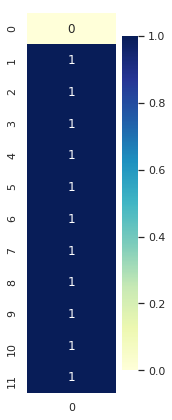

In [37]:
sns.set(rc={'figure.figsize':(2.0,7.0)})
sns.heatmap(df_h_s_attended_vector, annot=True, cmap='YlGnBu', )

# Between Sentences

In [38]:
model_s1 = Model(model.inputs,model.get_layer(name='sa1').output)
model_s2 = Model(model.inputs,model.get_layer(name='sa2').output)
model_s3 = Model(model.inputs,model.get_layer(name='sa3').output)
model_s4 = Model(model.inputs,model.get_layer(name='sa4').output)
model_s1.summary()
model_s2.summary()
model_s3.summary()
model_s4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sentence_vectors (InputLayer (None, 500, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 16)           14416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 32)           1568      
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 500, 32)           128       
_________________________________________________________________
sa1 (SelfAttention)          [(None, 500, 32), (500, 5 2377      
Total para

In [39]:
_, sb1, sg1 = model_s1.predict([x['sentence_vectors'],x['input_headline_vector']])
_, sb2, sg2 = model_s2.predict(x)
_, sb3, sg3 = model_s3.predict(x)
_, sb4, sg4 = model_s4.predict(x)

In [40]:
sb = sb1[test_idx]#+sb2[test_idx]+sb3[test_idx]+sb4[test_idx]
sb = sb[:len(x['sentences'][test_idx]),:len(x['sentences'][test_idx])]

sb.shape

(12, 12)

In [41]:
df_sb = pd.DataFrame(sb)


# zx = df_sb.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# zx_scaled = min_max_scaler.fit_transform(zx)
# df_sb = pd.DataFrame(zx_scaled)

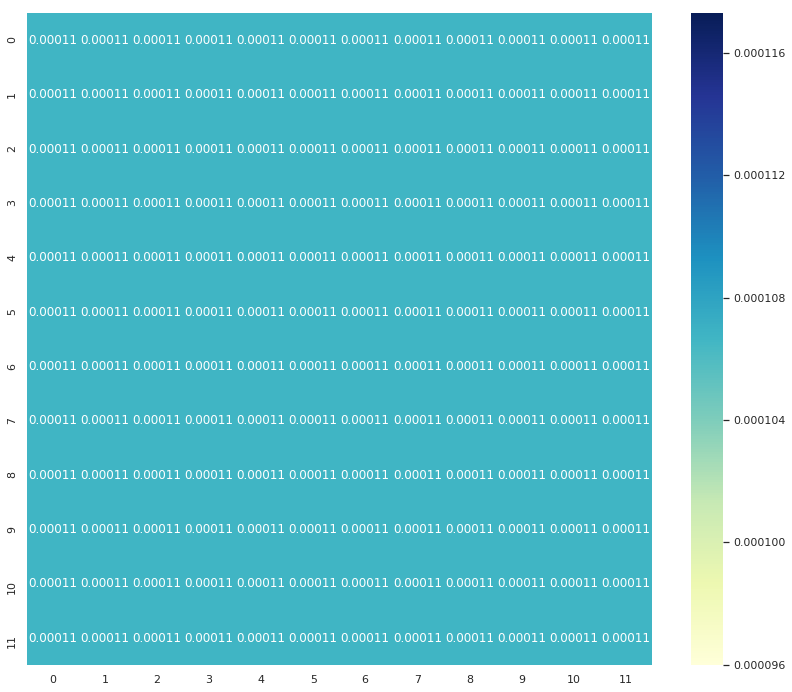

In [42]:
sns.set(rc={'figure.figsize':(14.0,12.0)})
sns.heatmap(pd.DataFrame(df_sb),annot=True,cmap='YlGnBu')

In [43]:
pd.DataFrame(x['sentences'][test_idx])

,0
0,"Before running against billionaire real estate mogul Donald Trump for the presidency, Secretary of State Hillary Clinton told an audience at a private, paid speech she wanted to see more successful businessmen and women run for office because they can’t be bought."
1,"In a speech made public by Wikileaks – which released an email from Hillary for America Research Director Tony Caark containing three attached speeches given at a private Goldman Sachs events – Clinton spoke and took audience questions at the “Builders and Innovators Summit” hosted by Goldman Sachs on October 29, 2013."
2,"Answering a question about businessmen in politics, Clinton said that they are “most often the people that look over the horizon,” and therefore share a vision that many politicians of today lack. “"
3,And that’s a very good question and thank you for asking it.
4,"Yes, I would love to see more businessmen go into politics because I believe they would bring in an entirely different mindset and strategies than what we’re used to seeing traditionally,” she opined."
5,And then she just had to go on. “
6,"In fact, when you say businessmen and women, I can’t help but think of a particular one that I would just love to see running for the presidency at some point in the future,” Clinton added. “"
7,"I don’t know what it is exactly about him, I can’t quite put my finger on it, but my instinct is almost never wrong."
8,And it’s telling me that Donald Trump would be very successful if he were to venture into politics in the future.”
9,"Asked to elaborate on her statement, the former Secretary of State argued that she thinks that businessmen “can’t be bought” and that they’re “very honest.” “"


In [44]:

def datagen_dnf_eval():

    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]

    for idx in dnf_eval.id: 
        hd = dnf_eval[dnf_eval.id==idx]['headline'].values[0].lower()
        ar_id = dnf_eval[dnf_eval.id==idx]['id'].values[0]
        cl = dnf_eval[dnf_eval.id==idx]['claim_ids'].values[0]
        ar_claims.append(cl)
        sentences = articles300[ar_id]
        vectors = article_vectors300[ar_id]


        hds.append(hd)
        ar_sentences.append(sentences)
    #         print(len(sentences))
        sents = np.zeros((max_sentences,300))

        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        hd_nlp = hd_nlp[:50]
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))

        inputs = {
            'article_id': np.array(ar_ids)
            ,'headline': np.array(hds)
            ,'sentence_vectors' : np.array(ar_sents)
            ,'input_headline_vector': np.array(ar_head_vectors)
            ,'claims':np.array(ar_claims)
            ,'sentences':np.array(ar_sentences)
        }
        outputs = {
            'headline_token_classes': np.array(ar_head_classes)
            ,'output_headline_vector': np.array(ar_head_vectors)
        }
    return inputs,outputs
testX,testY = datagen_dnf_eval()

In [45]:

# display(testX['headline'])

# Evaluation for P, R, F1

In [46]:

best_N = 5
_, b1, g1 = model_1.predict(testX)
_, b2, g2 = model_2.predict(testX)
_, b3, g3 = model_3.predict(testX)
_, b4, g4 = model_4.predict(testX)
ps, rs = [],[]
counter=0
for test_idx in range(len(testX['headline'])):    
    tp,fp,fn = 0,0,0
    claims = np.array(testX['claims'][test_idx])
#     sentences = list(range(len(articles[test_idx])))
    b = b1[test_idx]+b2[test_idx]+b3[test_idx]+b4[test_idx]
    pred = b[0][:len(testX['sentences'][test_idx])].argsort()[-best_N:][::-1]
    
#     print('claims:',claims)
#     print('pred:',pred)
    for p in pred:
        if p in claims:
            tp+=1
        else:
            fp+=1
    for c in claims:
        if c not in pred:
            fn+=1
    p = tp/(tp+fp)
    r = tp/(tp+fn)
#     print()
#     tn = sentences - list(set(list(pred)+list(claims)))
#     print(test_idx,', article id:',x['article_id'][test_idx], ',# sentences:',len(articles[x['article_id'][test_idx]]),":",p,r)
    ps.append(p)
    rs.append(r)
#     counter+=1
#     if counter==5:
#         break
#     print("----------------------------")
#     for s in t:
#         if s>=len(x['sentences'][test_idx]):continue
#         x['sentences'][test_idx][s]
np.average(ps), np.average(rs), 2*np.average(ps)*np.average(rs)/(np.average(ps)+ np.average(rs))

(0.405, 0.5403333333333333, 0.4629795486600846)

In [50]:
df_hd_tp_cdc = pd.read_csv('evaluation_set/cdc_ibm/headline_topic_mapping.csv')
df_ar_cl_cdc = pd.read_csv('evaluation_set/cdc_ibm/article_claim_mapping.csv')
df_hd_tp_dnf = pd.read_json('evaluation_set/deepnofakes/Evaluation_Final_50_V4.json')
df_hd_tp_dnf.columns = ['authors','claim_ids', 'evidence', 'headline', 'id', 'reason', 'claims', 'type', 'urls']
with open('evaluation_set/cdc_ibm/articles.p', 'rb') as fp:
    articles = pickle.load(fp)
with open('evaluation_set/cdc_ibm/article_vectors.p', 'rb') as fp:
    article_vectors = pickle.load(fp)
with open('evaluation_set/word_mapping/id_word_mapping.p', 'rb') as fp:
    id_word_mapping = pickle.load(fp)
df_hd_tp_cdc.keys(),df_ar_cl_cdc.keys(), len(articles.keys()), len(article_vectors.keys()), df_hd_tp_dnf.keys()
test_titles = []
for ar in df_ar_cl_cdc.Article.unique():
    if len(df_ar_cl_cdc[df_ar_cl_cdc.Article==ar]['Claim'].values)>8:
        test_titles.append(ar)
ar_ids,ar_sents,ar_sentences,ar_head_vectors,ar_head_classes,hds,claims=[],[],[],[],[],[],[]
for idx in tqdm_notebook(test_titles):
#     print(idx)
    hd = df_hd_tp_cdc[df_hd_tp_cdc.Title==idx]['Headline'].values[0].lower()
    hds.append(hd)
    ar_id = df_hd_tp_cdc[df_hd_tp_cdc.Title==idx]['article Id'].values[0]
    cl = df_ar_cl_cdc[df_ar_cl_cdc.Article==idx]['Claim'].values
    claims.append(cl)
#     sentences=articles[ar_id]
#     ar_sentences.append(ar_sentences)
    #         print(len(sentences))
    sents = np.zeros((max_sentences,300))
    vectors = article_vectors[ar_id]
    sents[:len(vectors)] = vectors[:max_sentences]
    ar_ids.append(ar_id)
    ar_sents.append(sents)
    hd_nlp = nlp(hd.lower())
    head_classes = np.zeros(50, dtype='int')
    for i in range(len(hd_nlp)):
        head_classes[i] = hd_nlp[i].rank
    ar_head_vectors.append(hd_nlp.vector)
    ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
inputs = {
    'article_id': np.array(ar_ids)
    ,'headline': np.array(hds)
    ,'sentence_vectors' : np.array(ar_sents)
#     ,'sentences' : np.array(ar_sentences)
    ,'input_headline_vector': np.array(ar_head_vectors)
    ,'claims':np.array(claims)
}
outputs = {
    'headline_token_classes': np.array(ar_head_classes)
    ,'output_headline_vector': np.array(ar_head_vectors)
}
threshold = 0.95
best_N = 5
_, b1, g1 = model_1.predict(inputs)
_, b2, g2 = model_2.predict(inputs)
_, b3, g3 = model_3.predict(inputs)
_, b4, g4 = model_4.predict(inputs)
ps, rs = [],[]
counter=0
for test_idx in tqdm_notebook(range(len(inputs['headline']))):    
    tp,fp,fn = 0,0,0
    claims = np.array(inputs['claims'][test_idx])
#     sentences = list(range(len(articles[test_idx])))
    b = b1[test_idx]+b2[test_idx]+b3[test_idx]+b4[test_idx]
    ids = b[0][:len(articles[inputs['article_id'][test_idx]])].argsort()[-best_N:][::-1]
#     print(ids)
    pred = np.array(articles[inputs['article_id'][test_idx]])[ids]
#     print('claims:',claims)
#     print('pred:',pred)
    for i in range(len(pred)):
    #     print('===========***********',i,'***********============')
        t5 = nlp(str(pred[i]))
        flag = False
        #pred_claim_sent.append(pred[i])
    #     print(t5.vector)
        for j in range(len(cl)):
            _c = nlp(cl[j])
    #         print(_c.vector)
    #         print('top_5:',t5.text)
    #         print('-------------------')
    #         print('ground_truth:',_c.text)
    #         print('t5:{0}, cl:{1}, sim: {2}'.format(i,j,np.around(t5.similarity(_c),4)))
    #         print('===================================================================')
            if np.around(t5.similarity(_c),4) > threshold:
                tp+=1
                flag = True
                break
        if flag is False:
            fp+=1
        
            
   
    #     print(t5.vector)
    for j in range(len(cl)):
        _c = nlp(cl[j])
        flag = False
        for i in range(len(pred)):
    #     print('===========***********',i,'***********============')
            t5 = nlp(str(pred[i]))
        
    #         print(_c.vector)
    #         print('top_5:',t5.text)
    #         print('-------------------')
    #         print('ground_truth:',_c.text)
    #         print('t5:{0}, cl:{1}, sim: {2}'.format(i,j,np.around(t5.similarity(_c),4)))
    #         print('===================================================================')
            if np.around(t5.similarity(_c),4) > threshold:
                flag = True
                break
        if flag is False:
            fn+=1
         
    p = tp/(tp+fp)
    r = tp/(tp+fn)
#     print()
#     tn = sentences - list(set(list(pred)+list(claims)))
#     print(test_idx,', article id:',x['article_id'][test_idx], ',# sentences:',len(articles[x['article_id'][test_idx]]),":",p,r)
    ps.append(p)
    rs.append(r)

np.average(ps), np.average(rs), 2*np.average(ps)*np.average(rs)/(np.average(ps)+ np.average(rs))

(0.20425531914893613, 0.08813007323645622, 0.12313225423932511)